In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

In [2]:
train_path = "../input/augmented-alzheimer-mri-dataset-v2/data/train"
test_path = "../input/augmented-alzheimer-mri-dataset-v2/data/val"

img_height, img_width = 125, 125
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode = "categorical",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode = "categorical",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 33984 files belonging to 4 classes.


2022-10-07 16:17:34.445608: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 16:17:34.537665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 16:17:34.538400: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 16:17:34.545758: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 6400 files belonging to 4 classes.


# Models #

In [3]:
models = dict()
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
loss = "categorical_crossentropy"
metrics = ["accuracy", "AUC"]

earlystop = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-3,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience = 10,
        verbose=1,
    )
]

callbacks = dict()

### EfficientNetB2 ###

In [4]:
efnb2_model = tf.keras.models.Sequential(name = "EfficientNetB2")

#pretrained 
pretrained_efnb2 = tf.keras.applications.EfficientNetB2(
    include_top = False,
    weights="imagenet",
    input_shape= (img_height, img_width, 3),
    pooling='max',
    classes=4,
)

#freeze layers
for layer in pretrained_efnb2.layers:
    layer.trainable = False

#Add new trainable weights
efnb2_model.add(pretrained_efnb2)
efnb2_model.add(Flatten())
efnb2_model.add(Dense(512, activation = 'relu'))
efnb2_model.add(Dense(256, activation = 'relu'))
efnb2_model.add(Dropout(0.3))
efnb2_model.add(Dense(4, activation = 'softmax'))

#Compile Model
efnb2_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="EfficientNetB2_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )]

efnb2_callbacks.extend(earlystop)
efnb2_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
efnb2_model.summary()

models["efnb2"] = efnb2_model
callbacks["efnb2"] = efnb2_callbacks

31801344/31790344 [==============================] - 0s 0us/step
Model: "EfficientNetB2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb2 (Functional)  (None, 1408)              7768569   
_________________________________________________________________
flatten (Flatten)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               721408    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 8,622,333
Trainable params: 853,764
Non

### Xception Net ###

In [5]:
Xception_model = tf.keras.models.Sequential(name = "Xception")

#pretrained 
pretrained_Xception= tf.keras.applications.Xception(
    include_top = False,
    weights="imagenet",
    input_shape= (img_height, img_width, 3),
    pooling='max',
    classes=4,
)

#freeze layers
for layer in pretrained_Xception.layers:
    layer.trainable = False

#Add new trainable weights
Xception_model.add(pretrained_Xception)
Xception_model.add(Flatten())
Xception_model.add(Dense(512, activation = 'relu'))
Xception_model.add(Dense(256, activation = 'relu'))
Xception_model.add(Dropout(0.3))
Xception_model.add(Dense(4, activation = 'softmax'))

#Compile Model
Xception_model.compile(loss = loss, optimizer = optimizer, metrics = metrics)
Xception_model.summary()
models["Xception"] = Xception_model

#Callbacks
Xception_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="Xception_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )]
Xception_callbacks.extend(earlystop)
callbacks["Xception"] = Xception_callbacks


83697664/83683744 [==============================] - 0s 0us/step
Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 22,042,924
Trainable params: 1,181,444
Non-tr

# Train #

In [6]:
def plot_history(history):
    fig, ax = plt.subplots(1,3, figsize = (20,5))
    #ax.set_xlabel('Epoch')
    #ax.set_ylabel('Metric')
    #ax.set_title("Title")
    
    ax[0].set_title("Accuracy", fontsize = 20)
    ax[1].set_title("AUC", fontsize = 20)
    ax[2].set_title("Loss", fontsize = 20)
    
    metrics = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'loss', 'val_loss']
    
    history = history.history
        
    for i, metric in enumerate(metrics):
        i = i//2
        ax[i].set_xticks(np.arange(0, 30, 1))
        ax[i].plot(history[metric], 'o--')
    
    fig.tight_layout()
    fig.legend(labels = ["train", "validation"], loc="upper right")
    plt.subplots_adjust(right=0.98)

    plt.show()

In [7]:
epochs = 100
histories = dict()
for m in models:
    #fit
    print(models[m].name)
    history = models[m].fit(train_ds, validation_data = val_ds, epochs = epochs, callbacks = callbacks[m])
    histories[m] = history

EfficientNetB2
Epoch 1/100


2022-10-07 16:17:56.413707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-07 16:17:59.695017: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1062/1062 [==============================] - 168s 144ms/step - loss: 1.1879 - accuracy: 0.4629 - auc: 0.7374 - val_loss: 0.9609 - val_accuracy: 0.5309 - val_auc: 0.8236

Epoch 00001: val_loss improved from inf to 0.96088, saving model to EfficientNetB2_1


2022-10-07 16:20:55.658131: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.9657 - accuracy: 0.5656 - auc: 0.8297 - val_loss: 0.9032 - val_accuracy: 0.5419 - val_auc: 0.8419

Epoch 00002: val_loss improved from 0.96088 to 0.90324, saving model to EfficientNetB2_2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.8840 - accuracy: 0.6028 - auc: 0.8579 - val_loss: 0.8336 - val_accuracy: 0.5987 - val_auc: 0.8659

Epoch 00003: val_loss improved from 0.90324 to 0.83363, saving model to EfficientNetB2_3


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
1062/1062 [==============================] - 43s 41ms/step - loss: 0.8345 - accuracy: 0.6222 - auc: 0.8730 - val_loss: 0.8934 - val_accuracy: 0.5788 - val_auc: 0.8484

Epoch 00004: val_loss did not improve from 0.83363
Epoch 5/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.7943 - accuracy: 0.6405 - auc: 0.8847 - val_loss: 0.7757 - val_accuracy: 0.6523 - val_auc: 0.8894

Epoch 00005: val_loss improved from 0.83363 to 0.77565, saving model to EfficientNetB2_5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.7638 - accuracy: 0.6578 - auc: 0.8940 - val_loss: 0.8456 - val_accuracy: 0.6094 - val_auc: 0.8654

Epoch 00006: val_loss did not improve from 0.77565
Epoch 7/100
1062/1062 [==============================] - 43s 41ms/step - loss: 0.7455 - accuracy: 0.6665 - auc: 0.8986 - val_loss: 0.7238 - val_accuracy: 0.6469 - val_auc: 0.8988

Epoch 00007: val_loss improved from 0.77565 to 0.72376, saving model to EfficientNetB2_7


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.7119 - accuracy: 0.6821 - auc: 0.9078 - val_loss: 0.7504 - val_accuracy: 0.6505 - val_auc: 0.8933

Epoch 00008: val_loss did not improve from 0.72376
Epoch 9/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.6936 - accuracy: 0.6894 - auc: 0.9125 - val_loss: 0.6642 - val_accuracy: 0.6977 - val_auc: 0.9186

Epoch 00009: val_loss improved from 0.72376 to 0.66425, saving model to EfficientNetB2_9


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.6746 - accuracy: 0.7012 - auc: 0.9175 - val_loss: 0.6902 - val_accuracy: 0.6698 - val_auc: 0.9086

Epoch 00010: val_loss did not improve from 0.66425
Epoch 11/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.6598 - accuracy: 0.7054 - auc: 0.9210 - val_loss: 0.6179 - val_accuracy: 0.7175 - val_auc: 0.9279

Epoch 00011: val_loss improved from 0.66425 to 0.61792, saving model to EfficientNetB2_11


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 12/100
1062/1062 [==============================] - 43s 41ms/step - loss: 0.6431 - accuracy: 0.7160 - auc: 0.9250 - val_loss: 0.6529 - val_accuracy: 0.7055 - val_auc: 0.9202

Epoch 00012: val_loss did not improve from 0.61792
Epoch 13/100
1062/1062 [==============================] - 43s 41ms/step - loss: 0.6262 - accuracy: 0.7241 - auc: 0.9289 - val_loss: 0.6462 - val_accuracy: 0.7052 - val_auc: 0.9213

Epoch 00013: val_loss did not improve from 0.61792
Epoch 14/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.6120 - accuracy: 0.7298 - auc: 0.9322 - val_loss: 0.5947 - val_accuracy: 0.7184 - val_auc: 0.9321

Epoch 00014: val_loss improved from 0.61792 to 0.59471, saving model to EfficientNetB2_14


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.5996 - accuracy: 0.7352 - auc: 0.9347 - val_loss: 0.6059 - val_accuracy: 0.7216 - val_auc: 0.9307

Epoch 00015: val_loss did not improve from 0.59471
Epoch 16/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.5856 - accuracy: 0.7452 - auc: 0.9381 - val_loss: 0.5155 - val_accuracy: 0.7720 - val_auc: 0.9515

Epoch 00016: val_loss improved from 0.59471 to 0.51554, saving model to EfficientNetB2_16


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.5810 - accuracy: 0.7486 - auc: 0.9392 - val_loss: 0.5138 - val_accuracy: 0.7734 - val_auc: 0.9510

Epoch 00017: val_loss improved from 0.51554 to 0.51385, saving model to EfficientNetB2_17


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.5604 - accuracy: 0.7559 - auc: 0.9434 - val_loss: 0.6032 - val_accuracy: 0.7314 - val_auc: 0.9323

Epoch 00018: val_loss did not improve from 0.51385
Epoch 19/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.5535 - accuracy: 0.7602 - auc: 0.9447 - val_loss: 0.4849 - val_accuracy: 0.7867 - val_auc: 0.9565

Epoch 00019: val_loss improved from 0.51385 to 0.48486, saving model to EfficientNetB2_19


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 20/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.5414 - accuracy: 0.7661 - auc: 0.9471 - val_loss: 0.4766 - val_accuracy: 0.7920 - val_auc: 0.9571

Epoch 00020: val_loss improved from 0.48486 to 0.47659, saving model to EfficientNetB2_20


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.5314 - accuracy: 0.7685 - auc: 0.9490 - val_loss: 0.4826 - val_accuracy: 0.7848 - val_auc: 0.9555

Epoch 00021: val_loss did not improve from 0.47659
Epoch 22/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.5146 - accuracy: 0.7792 - auc: 0.9521 - val_loss: 0.4589 - val_accuracy: 0.7983 - val_auc: 0.9603

Epoch 00022: val_loss improved from 0.47659 to 0.45886, saving model to EfficientNetB2_22


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/100
1062/1062 [==============================] - 46s 43ms/step - loss: 0.5129 - accuracy: 0.7789 - auc: 0.9526 - val_loss: 0.4473 - val_accuracy: 0.8037 - val_auc: 0.9626

Epoch 00023: val_loss improved from 0.45886 to 0.44728, saving model to EfficientNetB2_23


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.5018 - accuracy: 0.7860 - auc: 0.9548 - val_loss: 0.3998 - val_accuracy: 0.8334 - val_auc: 0.9723

Epoch 00024: val_loss improved from 0.44728 to 0.39984, saving model to EfficientNetB2_24


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.4904 - accuracy: 0.7906 - auc: 0.9566 - val_loss: 0.5507 - val_accuracy: 0.7595 - val_auc: 0.9446

Epoch 00025: val_loss did not improve from 0.39984
Epoch 26/100
1062/1062 [==============================] - 46s 43ms/step - loss: 0.4791 - accuracy: 0.7961 - auc: 0.9588 - val_loss: 0.4064 - val_accuracy: 0.8256 - val_auc: 0.9692

Epoch 00026: val_loss did not improve from 0.39984
Epoch 27/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.4726 - accuracy: 0.7988 - auc: 0.9597 - val_loss: 0.3791 - val_accuracy: 0.8420 - val_auc: 0.9736

Epoch 00027: val_loss improved from 0.39984 to 0.37913, saving model to EfficientNetB2_27


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/100
1062/1062 [==============================] - 46s 44ms/step - loss: 0.4617 - accuracy: 0.8030 - auc: 0.9616 - val_loss: 0.4063 - val_accuracy: 0.8252 - val_auc: 0.9686

Epoch 00028: val_loss did not improve from 0.37913
Epoch 29/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.4603 - accuracy: 0.8061 - auc: 0.9619 - val_loss: 0.3543 - val_accuracy: 0.8542 - val_auc: 0.9777

Epoch 00029: val_loss improved from 0.37913 to 0.35431, saving model to EfficientNetB2_29


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 30/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.4544 - accuracy: 0.8087 - auc: 0.9629 - val_loss: 0.3953 - val_accuracy: 0.8405 - val_auc: 0.9716

Epoch 00030: val_loss did not improve from 0.35431
Epoch 31/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.4429 - accuracy: 0.8136 - auc: 0.9646 - val_loss: 0.3731 - val_accuracy: 0.8459 - val_auc: 0.9741

Epoch 00031: val_loss did not improve from 0.35431
Epoch 32/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.4350 - accuracy: 0.8161 - auc: 0.9659 - val_loss: 0.3690 - val_accuracy: 0.8528 - val_auc: 0.9748

Epoch 00032: val_loss did not improve from 0.35431
Epoch 33/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.4374 - accuracy: 0.8179 - auc: 0.9657 - val_loss: 0.3534 - val_accuracy: 0.8534 - val_auc: 0.9768

Epoch 00033: val_loss improved from 0.35431 to 0.35342, saving model to EfficientNetB2_33


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/100
1062/1062 [==============================] - 46s 43ms/step - loss: 0.4295 - accuracy: 0.8207 - auc: 0.9668 - val_loss: 0.3285 - val_accuracy: 0.8750 - val_auc: 0.9816

Epoch 00034: val_loss improved from 0.35342 to 0.32855, saving model to EfficientNetB2_34


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 35/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.4120 - accuracy: 0.8275 - auc: 0.9694 - val_loss: 0.4453 - val_accuracy: 0.8175 - val_auc: 0.9641

Epoch 00035: val_loss did not improve from 0.32855
Epoch 36/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.4105 - accuracy: 0.8294 - auc: 0.9697 - val_loss: 0.3507 - val_accuracy: 0.8556 - val_auc: 0.9771

Epoch 00036: val_loss did not improve from 0.32855
Epoch 37/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.4086 - accuracy: 0.8294 - auc: 0.9699 - val_loss: 0.3190 - val_accuracy: 0.8720 - val_auc: 0.9807

Epoch 00037: val_loss improved from 0.32855 to 0.31900, saving model to EfficientNetB2_37


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 38/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3987 - accuracy: 0.8359 - auc: 0.9714 - val_loss: 0.3663 - val_accuracy: 0.8520 - val_auc: 0.9746

Epoch 00038: val_loss did not improve from 0.31900
Epoch 39/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.3903 - accuracy: 0.8392 - auc: 0.9726 - val_loss: 0.2784 - val_accuracy: 0.8869 - val_auc: 0.9858

Epoch 00039: val_loss improved from 0.31900 to 0.27842, saving model to EfficientNetB2_39


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 40/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.3874 - accuracy: 0.8402 - auc: 0.9728 - val_loss: 0.2923 - val_accuracy: 0.8869 - val_auc: 0.9838

Epoch 00040: val_loss did not improve from 0.27842
Epoch 41/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3855 - accuracy: 0.8370 - auc: 0.9730 - val_loss: 0.3082 - val_accuracy: 0.8783 - val_auc: 0.9821

Epoch 00041: val_loss did not improve from 0.27842
Epoch 42/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.3746 - accuracy: 0.8450 - auc: 0.9746 - val_loss: 0.2740 - val_accuracy: 0.8889 - val_auc: 0.9860

Epoch 00042: val_loss improved from 0.27842 to 0.27404, saving model to EfficientNetB2_42


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 43/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3721 - accuracy: 0.8467 - auc: 0.9750 - val_loss: 0.2375 - val_accuracy: 0.9056 - val_auc: 0.9900

Epoch 00043: val_loss improved from 0.27404 to 0.23752, saving model to EfficientNetB2_43


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 44/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3699 - accuracy: 0.8465 - auc: 0.9752 - val_loss: 0.2522 - val_accuracy: 0.9034 - val_auc: 0.9892

Epoch 00044: val_loss did not improve from 0.23752
Epoch 45/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3591 - accuracy: 0.8525 - auc: 0.9766 - val_loss: 0.2327 - val_accuracy: 0.9092 - val_auc: 0.9903

Epoch 00045: val_loss improved from 0.23752 to 0.23269, saving model to EfficientNetB2_45


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 46/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.3564 - accuracy: 0.8543 - auc: 0.9770 - val_loss: 0.2853 - val_accuracy: 0.8875 - val_auc: 0.9846

Epoch 00046: val_loss did not improve from 0.23269
Epoch 47/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3453 - accuracy: 0.8598 - auc: 0.9784 - val_loss: 0.2152 - val_accuracy: 0.9134 - val_auc: 0.9917

Epoch 00047: val_loss improved from 0.23269 to 0.21519, saving model to EfficientNetB2_47


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 48/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.3487 - accuracy: 0.8583 - auc: 0.9779 - val_loss: 0.2096 - val_accuracy: 0.9214 - val_auc: 0.9930

Epoch 00048: val_loss improved from 0.21519 to 0.20956, saving model to EfficientNetB2_48


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 49/100
1062/1062 [==============================] - 48s 44ms/step - loss: 0.3469 - accuracy: 0.8601 - auc: 0.9783 - val_loss: 0.2102 - val_accuracy: 0.9152 - val_auc: 0.9921

Epoch 00049: val_loss did not improve from 0.20956
Epoch 50/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.3380 - accuracy: 0.8652 - auc: 0.9792 - val_loss: 0.1973 - val_accuracy: 0.9259 - val_auc: 0.9931

Epoch 00050: val_loss improved from 0.20956 to 0.19729, saving model to EfficientNetB2_50


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 51/100
1062/1062 [==============================] - 49s 46ms/step - loss: 0.3312 - accuracy: 0.8637 - auc: 0.9801 - val_loss: 0.2259 - val_accuracy: 0.9125 - val_auc: 0.9904

Epoch 00051: val_loss did not improve from 0.19729
Epoch 52/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.3285 - accuracy: 0.8676 - auc: 0.9804 - val_loss: 0.2228 - val_accuracy: 0.9125 - val_auc: 0.9906

Epoch 00052: val_loss did not improve from 0.19729
Epoch 53/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3288 - accuracy: 0.8670 - auc: 0.9803 - val_loss: 0.1868 - val_accuracy: 0.9273 - val_auc: 0.9936

Epoch 00053: val_loss improved from 0.19729 to 0.18685, saving model to EfficientNetB2_53


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 54/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3187 - accuracy: 0.8713 - auc: 0.9814 - val_loss: 0.2237 - val_accuracy: 0.9117 - val_auc: 0.9902

Epoch 00054: val_loss did not improve from 0.18685
Epoch 55/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3166 - accuracy: 0.8726 - auc: 0.9818 - val_loss: 0.2162 - val_accuracy: 0.9177 - val_auc: 0.9912

Epoch 00055: val_loss did not improve from 0.18685
Epoch 56/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3183 - accuracy: 0.8717 - auc: 0.9815 - val_loss: 0.1944 - val_accuracy: 0.9272 - val_auc: 0.9932

Epoch 00056: val_loss did not improve from 0.18685
Epoch 57/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.3125 - accuracy: 0.8735 - auc: 0.9821 - val_loss: 0.1977 - val_accuracy: 0.9233 - val_auc: 0.9928

Epoch 00057: val_loss did not improve from 0.18685
Epoch 58/100
1062/1062 [==============================] - 47s 44ms/step 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 59/100
1062/1062 [==============================] - 49s 46ms/step - loss: 0.3048 - accuracy: 0.8767 - auc: 0.9830 - val_loss: 0.2473 - val_accuracy: 0.9011 - val_auc: 0.9880

Epoch 00059: val_loss did not improve from 0.17619
Epoch 60/100
1062/1062 [==============================] - 46s 44ms/step - loss: 0.3008 - accuracy: 0.8787 - auc: 0.9835 - val_loss: 0.1841 - val_accuracy: 0.9273 - val_auc: 0.9934

Epoch 00060: val_loss did not improve from 0.17619
Epoch 61/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.2994 - accuracy: 0.8791 - auc: 0.9836 - val_loss: 0.1771 - val_accuracy: 0.9331 - val_auc: 0.9941

Epoch 00061: val_loss did not improve from 0.17619
Epoch 62/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.2950 - accuracy: 0.8821 - auc: 0.9840 - val_loss: 0.1780 - val_accuracy: 0.9316 - val_auc: 0.9941

Epoch 00062: val_loss did not improve from 0.17619
Epoch 63/100
1062/1062 [==============================] - 47s 44ms/step 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 64/100
1062/1062 [==============================] - 49s 46ms/step - loss: 0.2857 - accuracy: 0.8856 - auc: 0.9850 - val_loss: 0.1583 - val_accuracy: 0.9402 - val_auc: 0.9952

Epoch 00064: val_loss improved from 0.17062 to 0.15831, saving model to EfficientNetB2_64


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 65/100
1062/1062 [==============================] - 49s 46ms/step - loss: 0.2897 - accuracy: 0.8854 - auc: 0.9846 - val_loss: 0.2142 - val_accuracy: 0.9173 - val_auc: 0.9909

Epoch 00065: val_loss did not improve from 0.15831
Epoch 66/100
1062/1062 [==============================] - 52s 49ms/step - loss: 0.2863 - accuracy: 0.8855 - auc: 0.9850 - val_loss: 0.1425 - val_accuracy: 0.9461 - val_auc: 0.9963

Epoch 00066: val_loss improved from 0.15831 to 0.14249, saving model to EfficientNetB2_66


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 67/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.2814 - accuracy: 0.8871 - auc: 0.9854 - val_loss: 0.1611 - val_accuracy: 0.9370 - val_auc: 0.9948

Epoch 00067: val_loss did not improve from 0.14249
Epoch 68/100
1062/1062 [==============================] - 49s 46ms/step - loss: 0.2788 - accuracy: 0.8884 - auc: 0.9857 - val_loss: 0.1340 - val_accuracy: 0.9550 - val_auc: 0.9966

Epoch 00068: val_loss improved from 0.14249 to 0.13397, saving model to EfficientNetB2_68


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 69/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.2785 - accuracy: 0.8897 - auc: 0.9857 - val_loss: 0.1564 - val_accuracy: 0.9414 - val_auc: 0.9951

Epoch 00069: val_loss did not improve from 0.13397
Epoch 70/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.2762 - accuracy: 0.8880 - auc: 0.9859 - val_loss: 0.2319 - val_accuracy: 0.9103 - val_auc: 0.9895

Epoch 00070: val_loss did not improve from 0.13397
Epoch 71/100
1062/1062 [==============================] - 47s 44ms/step - loss: 0.2729 - accuracy: 0.8917 - auc: 0.9862 - val_loss: 0.1534 - val_accuracy: 0.9406 - val_auc: 0.9952

Epoch 00071: val_loss did not improve from 0.13397
Epoch 72/100
1062/1062 [==============================] - 48s 45ms/step - loss: 0.2719 - accuracy: 0.8924 - auc: 0.9864 - val_loss: 0.1587 - val_accuracy: 0.9405 - val_auc: 0.9948

Epoch 00072: val_loss did not improve from 0.13397
Epoch 73/100
1062/1062 [==============================] - 47s 44ms/step 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 00078: early stopping
Xception
Epoch 1/100
1062/1062 [==============================] - 50s 43ms/step - loss: 1.3240 - accuracy: 0.4639 - auc: 0.7386 - val_loss: 0.9218 - val_accuracy: 0.5247 - val_auc: 0.8308

Epoch 00001: val_loss improved from inf to 0.92183, saving model to Xception_1


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.9870 - accuracy: 0.5484 - auc: 0.8192 - val_loss: 0.9138 - val_accuracy: 0.5473 - val_auc: 0.8346

Epoch 00002: val_loss improved from 0.92183 to 0.91377, saving model to Xception_2


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.9196 - accuracy: 0.5796 - auc: 0.8433 - val_loss: 0.8713 - val_accuracy: 0.5644 - val_auc: 0.8508

Epoch 00003: val_loss improved from 0.91377 to 0.87129, saving model to Xception_3


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.8813 - accuracy: 0.5917 - auc: 0.8560 - val_loss: 0.9033 - val_accuracy: 0.5442 - val_auc: 0.8339

Epoch 00004: val_loss did not improve from 0.87129
Epoch 5/100
1062/1062 [==============================] - 42s 39ms/step - loss: 0.8500 - accuracy: 0.6119 - auc: 0.8667 - val_loss: 0.8777 - val_accuracy: 0.5639 - val_auc: 0.8453

Epoch 00005: val_loss did not improve from 0.87129
Epoch 6/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.8167 - accuracy: 0.6238 - auc: 0.8767 - val_loss: 0.7902 - val_accuracy: 0.6020 - val_auc: 0.8751

Epoch 00006: val_loss improved from 0.87129 to 0.79023, saving model to Xception_6


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.7915 - accuracy: 0.6379 - auc: 0.8843 - val_loss: 0.8553 - val_accuracy: 0.5795 - val_auc: 0.8556

Epoch 00007: val_loss did not improve from 0.79023
Epoch 8/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.7645 - accuracy: 0.6545 - auc: 0.8926 - val_loss: 0.7992 - val_accuracy: 0.6194 - val_auc: 0.8751

Epoch 00008: val_loss did not improve from 0.79023
Epoch 9/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.7391 - accuracy: 0.6621 - auc: 0.8992 - val_loss: 0.7460 - val_accuracy: 0.6311 - val_auc: 0.8898

Epoch 00009: val_loss improved from 0.79023 to 0.74597, saving model to Xception_9


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.7173 - accuracy: 0.6766 - auc: 0.9057 - val_loss: 0.7281 - val_accuracy: 0.6466 - val_auc: 0.8962

Epoch 00010: val_loss improved from 0.74597 to 0.72805, saving model to Xception_10


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.6905 - accuracy: 0.6874 - auc: 0.9124 - val_loss: 0.7307 - val_accuracy: 0.6578 - val_auc: 0.8970

Epoch 00011: val_loss did not improve from 0.72805
Epoch 12/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.6632 - accuracy: 0.7028 - auc: 0.9197 - val_loss: 0.7277 - val_accuracy: 0.6552 - val_auc: 0.8972

Epoch 00012: val_loss improved from 0.72805 to 0.72766, saving model to Xception_12


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.6444 - accuracy: 0.7121 - auc: 0.9243 - val_loss: 0.6988 - val_accuracy: 0.6681 - val_auc: 0.9055

Epoch 00013: val_loss improved from 0.72766 to 0.69882, saving model to Xception_13


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.6223 - accuracy: 0.7248 - auc: 0.9296 - val_loss: 0.6385 - val_accuracy: 0.7000 - val_auc: 0.9209

Epoch 00014: val_loss improved from 0.69882 to 0.63846, saving model to Xception_14


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.6009 - accuracy: 0.7354 - auc: 0.9344 - val_loss: 0.5986 - val_accuracy: 0.7291 - val_auc: 0.9318

Epoch 00015: val_loss improved from 0.63846 to 0.59865, saving model to Xception_15


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 16/100
1062/1062 [==============================] - 43s 40ms/step - loss: 0.5763 - accuracy: 0.7464 - auc: 0.9398 - val_loss: 0.5925 - val_accuracy: 0.7278 - val_auc: 0.9333

Epoch 00016: val_loss improved from 0.59865 to 0.59246, saving model to Xception_16


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/100
1062/1062 [==============================] - 42s 40ms/step - loss: 0.5546 - accuracy: 0.7549 - auc: 0.9443 - val_loss: 0.5798 - val_accuracy: 0.7341 - val_auc: 0.9365

Epoch 00017: val_loss improved from 0.59246 to 0.57979, saving model to Xception_17


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 18/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.5326 - accuracy: 0.7668 - auc: 0.9486 - val_loss: 0.5589 - val_accuracy: 0.7564 - val_auc: 0.9416

Epoch 00018: val_loss improved from 0.57979 to 0.55892, saving model to Xception_18


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 19/100
1062/1062 [==============================] - 43s 40ms/step - loss: 0.5096 - accuracy: 0.7780 - auc: 0.9531 - val_loss: 0.5688 - val_accuracy: 0.7522 - val_auc: 0.9407

Epoch 00019: val_loss did not improve from 0.55892
Epoch 20/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.4899 - accuracy: 0.7898 - auc: 0.9569 - val_loss: 0.5373 - val_accuracy: 0.7564 - val_auc: 0.9450

Epoch 00020: val_loss improved from 0.55892 to 0.53730, saving model to Xception_20


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 21/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.4738 - accuracy: 0.7964 - auc: 0.9595 - val_loss: 0.5122 - val_accuracy: 0.7759 - val_auc: 0.9507

Epoch 00021: val_loss improved from 0.53730 to 0.51218, saving model to Xception_21


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.4530 - accuracy: 0.8065 - auc: 0.9631 - val_loss: 0.5021 - val_accuracy: 0.7805 - val_auc: 0.9533

Epoch 00022: val_loss improved from 0.51218 to 0.50208, saving model to Xception_22


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/100
1062/1062 [==============================] - 43s 40ms/step - loss: 0.4393 - accuracy: 0.8126 - auc: 0.9654 - val_loss: 0.4455 - val_accuracy: 0.8112 - val_auc: 0.9625

Epoch 00023: val_loss improved from 0.50208 to 0.44551, saving model to Xception_23


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 24/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.4190 - accuracy: 0.8217 - auc: 0.9686 - val_loss: 0.4465 - val_accuracy: 0.8152 - val_auc: 0.9634

Epoch 00024: val_loss did not improve from 0.44551
Epoch 25/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.3986 - accuracy: 0.8300 - auc: 0.9715 - val_loss: 0.4522 - val_accuracy: 0.8152 - val_auc: 0.9619

Epoch 00025: val_loss did not improve from 0.44551
Epoch 26/100
1062/1062 [==============================] - 42s 40ms/step - loss: 0.3841 - accuracy: 0.8403 - auc: 0.9736 - val_loss: 0.4270 - val_accuracy: 0.8236 - val_auc: 0.9663

Epoch 00026: val_loss improved from 0.44551 to 0.42700, saving model to Xception_26


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.3713 - accuracy: 0.8437 - auc: 0.9753 - val_loss: 0.4229 - val_accuracy: 0.8286 - val_auc: 0.9668

Epoch 00027: val_loss improved from 0.42700 to 0.42291, saving model to Xception_27


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.3503 - accuracy: 0.8550 - auc: 0.9781 - val_loss: 0.4350 - val_accuracy: 0.8241 - val_auc: 0.9653

Epoch 00028: val_loss did not improve from 0.42291
Epoch 29/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.3434 - accuracy: 0.8591 - auc: 0.9788 - val_loss: 0.4240 - val_accuracy: 0.8300 - val_auc: 0.9667

Epoch 00029: val_loss did not improve from 0.42291
Epoch 30/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.3229 - accuracy: 0.8665 - auc: 0.9814 - val_loss: 0.4170 - val_accuracy: 0.8297 - val_auc: 0.9683

Epoch 00030: val_loss improved from 0.42291 to 0.41700, saving model to Xception_30


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 31/100
1062/1062 [==============================] - 44s 41ms/step - loss: 0.3156 - accuracy: 0.8700 - auc: 0.9821 - val_loss: 0.4332 - val_accuracy: 0.8239 - val_auc: 0.9652

Epoch 00031: val_loss did not improve from 0.41700
Epoch 32/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.3010 - accuracy: 0.8774 - auc: 0.9838 - val_loss: 0.3885 - val_accuracy: 0.8406 - val_auc: 0.9720

Epoch 00032: val_loss improved from 0.41700 to 0.38848, saving model to Xception_32


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 33/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.2873 - accuracy: 0.8819 - auc: 0.9852 - val_loss: 0.3794 - val_accuracy: 0.8531 - val_auc: 0.9733

Epoch 00033: val_loss improved from 0.38848 to 0.37944, saving model to Xception_33


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 34/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.2822 - accuracy: 0.8856 - auc: 0.9856 - val_loss: 0.4721 - val_accuracy: 0.8170 - val_auc: 0.9613

Epoch 00034: val_loss did not improve from 0.37944
Epoch 35/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.2677 - accuracy: 0.8914 - auc: 0.9871 - val_loss: 0.3611 - val_accuracy: 0.8584 - val_auc: 0.9754

Epoch 00035: val_loss improved from 0.37944 to 0.36114, saving model to Xception_35


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 36/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.2599 - accuracy: 0.8953 - auc: 0.9879 - val_loss: 0.4702 - val_accuracy: 0.8181 - val_auc: 0.9636

Epoch 00036: val_loss did not improve from 0.36114
Epoch 37/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.2442 - accuracy: 0.9021 - auc: 0.9894 - val_loss: 0.3690 - val_accuracy: 0.8559 - val_auc: 0.9753

Epoch 00037: val_loss did not improve from 0.36114
Epoch 38/100
1062/1062 [==============================] - 46s 44ms/step - loss: 0.2346 - accuracy: 0.9071 - auc: 0.9901 - val_loss: 0.3942 - val_accuracy: 0.8520 - val_auc: 0.9734

Epoch 00038: val_loss did not improve from 0.36114
Epoch 39/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.2276 - accuracy: 0.9085 - auc: 0.9906 - val_loss: 0.3997 - val_accuracy: 0.8523 - val_auc: 0.9727

Epoch 00039: val_loss did not improve from 0.36114
Epoch 40/100
1062/1062 [==============================] - 44s 41ms/step 

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 41/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.2118 - accuracy: 0.9174 - auc: 0.9918 - val_loss: 0.3492 - val_accuracy: 0.8662 - val_auc: 0.9775

Epoch 00041: val_loss did not improve from 0.32366
Epoch 42/100
1062/1062 [==============================] - 44s 42ms/step - loss: 0.2027 - accuracy: 0.9217 - auc: 0.9926 - val_loss: 0.3672 - val_accuracy: 0.8658 - val_auc: 0.9760

Epoch 00042: val_loss did not improve from 0.32366
Epoch 43/100
1062/1062 [==============================] - 43s 40ms/step - loss: 0.1951 - accuracy: 0.9220 - auc: 0.9931 - val_loss: 0.3498 - val_accuracy: 0.8727 - val_auc: 0.9785

Epoch 00043: val_loss did not improve from 0.32366
Epoch 44/100
1062/1062 [==============================] - 45s 42ms/step - loss: 0.1992 - accuracy: 0.9223 - auc: 0.9928 - val_loss: 0.4060 - val_accuracy: 0.8562 - val_auc: 0.9723

Epoch 00044: val_loss did not improve from 0.32366
Epoch 45/100
1062/1062 [==============================] - 45s 42ms/step 

efnb2


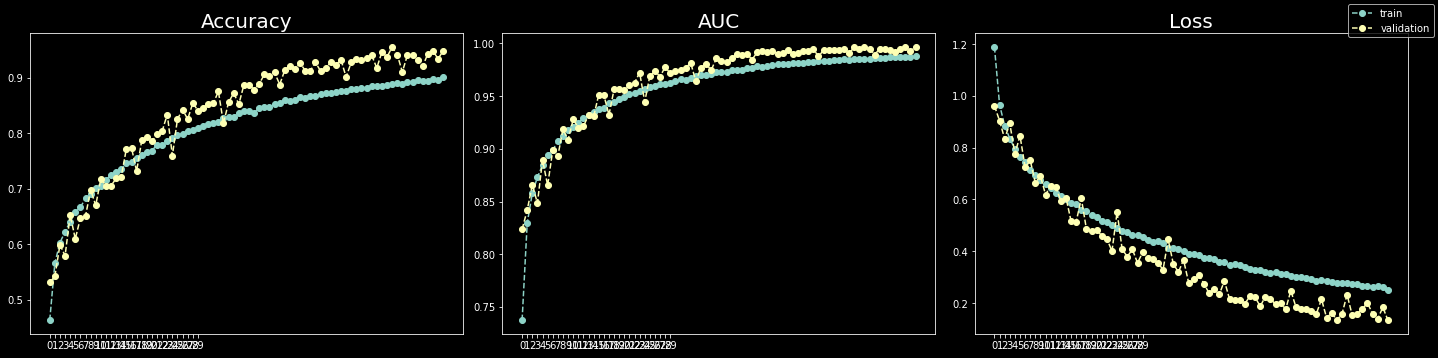

Xception


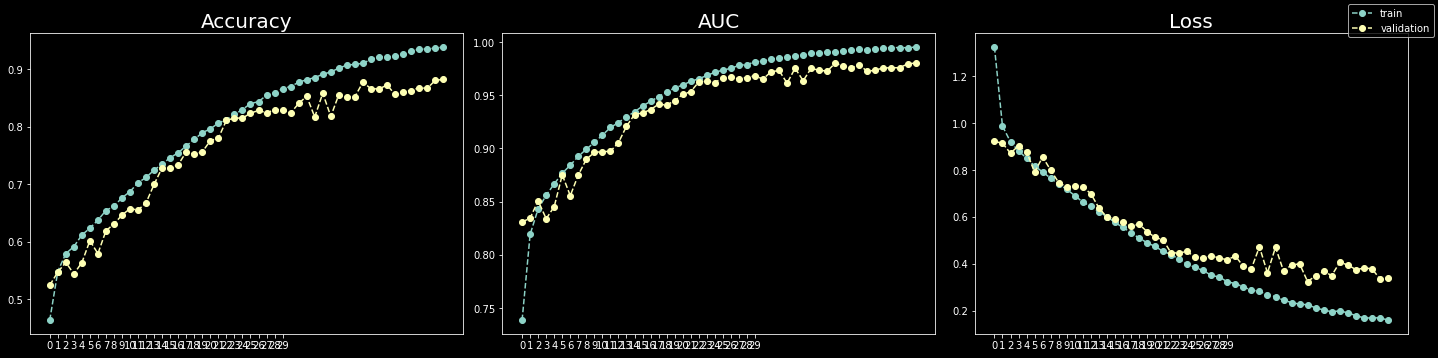

In [8]:
for key, history in histories.items():
    print(key)
    plot_history(history)